In [1]:
import numpy as np
import scipy as sp
from scipy import optimize
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def dilser(low=0.001, limit=100., dilfactor=2.):
    '''returns a numpy array dilution series from low to limit'''
    #replace this with a generator/iterator someday
    a = [low]
    while a[-1] <= limit:
        a.append(a[len(a)-1]*dilfactor)
    return np.array(a)

In [3]:
lig_concs = dilser()

In [4]:
def k1solv(var,parm,rtot,ltot):
    
    k1 = parm
    
    (L,R,RL) = var
    
    eq1 = R + RL - rtot
    eq2 = L + RL - ltot
    eq3 = k1 * R * L - RL
    
    return np.array([eq1,eq2,eq3])

In [5]:
def lognuniform(low=0, high=1, size=None, base=np.exp(1)):
    return np.power(base, np.random.uniform(low, high, size))

In [6]:
def guessgen(length,lowmag=-3,himag=3,base=10):
    return tuple(lognuniform(low=lowmag,high=himag,base=base) for i in range(length))

In [7]:
guesses = [guessgen(3) for i in range(500)]

In [8]:
res = [[sp.optimize.root(k1solv,i,args=(2.0,0.1,j),method='lm',options={'factor':0.1,'ftol':1e-14,'gtol':1e-14,'xtol':1e-14}).x for j in lig_concs] for i in guesses]

In [9]:
resc = np.array(res)

In [10]:
L = np.array([stats.mode(resc[:,i,0])[0][0] for i in range(18)])
R = np.array([stats.mode(resc[:,i,1])[0][0] for i in range(18)])
RL = np.array([stats.mode(resc[:,i,2])[0][0] for i in range(18)])

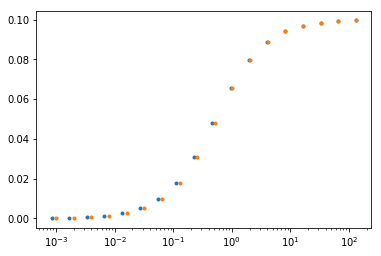

In [11]:
plt.semilogx(L,RL,'.')
plt.semilogx(lig_concs,RL,'.')

In [12]:
def k2solv(var,parm,rtot,ltot):
    
    k1 = parm[0]
    k2 = parm[1]
    
    (L,R,RL,RLL) = var
    
    eq1 = (R + RL + RLL) - rtot
    eq2 = (L + RL + 2*RLL) - ltot
    eq3 = (k1*R*L) - RL
    eq4 = (k2*k1*R*L*L) - RLL
    
    return np.array([eq1,eq2,eq3,eq4])

In [13]:
parmk2 = np.array([4.,1.])

In [14]:
k2guesses = [guessgen(4) for i in range(100)]
resk2 = [[optimize.root(k2solv,i,args=(parmk2,0.1,j),method='lm',options={'factor':0.1,'ftol':1e-14,'gtol':1e-14,'xtol':1e-14}).x for j in lig_concs] for i in k2guesses]

In [15]:
k2resc = np.array(resk2)

In [16]:
def find_best_root(data,max_lig_index,target_index,lig_max):
    """Returns "most reasonable" root solution from array of solutions
    based on known variables
    
    data -- the array of root solutions for a given binding equation
    max_lig_index -- length of starting ligand concentrations array
    target_index -- index of target solution in root solution tuple
    lig_max -- total receptor concentration used for solution
    """
    holder = []
    for i in range(max_lig_index):
        temp = np.around(data[:,i,target_index],decimals=8)
        holder.append(sp.stats.mode(np.extract(((temp > 0)&(temp < lig_max)),temp))[0][0])
    return np.array(holder)

In [17]:
dL = find_best_root(k2resc,18,0,150)
dR = find_best_root(k2resc,18,1,150)
dRL = find_best_root(k2resc,18,2,150)
dRLL = find_best_root(k2resc,18,3,150)

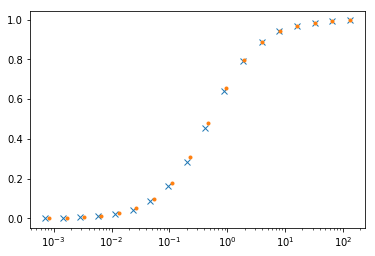

In [18]:
plt.semilogx(dL,((dRL + 2*dRLL)/(dR + dRL + dRLL))/2,'x')
plt.semilogx(L,RL/0.1,'.')

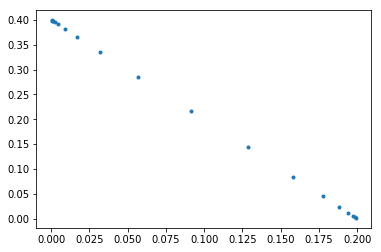

In [19]:
plt.plot((dRL + 2*dRLL),((dRL + 2*dRLL)/dL),'.')

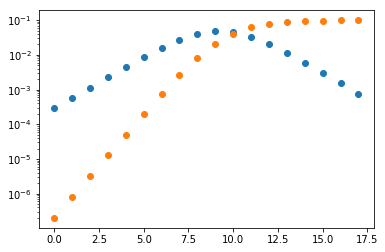

In [20]:
plt.semilogy(dRL,'o')
plt.semilogy(dRLL,'o')

In [21]:
def wymsol(var,parm,rtot,ltot):
    
    k11 = parm[0]
    k21 = parm[1]
    k22 = parm[2]
    l20 = parm[3]
    
    (L, M, MM, ML, MML, MMLL) = var
    
    eq1 = (M + 2*MM + ML + 2*MML + 2*MMLL) - rtot
    eq2 = (L + ML + MML + 2*MMLL) - ltot
    eq3 = (l20 * M*M) - MM
    eq4 = (k11 * L * M) - ML
    eq5 = (l20 * k21 * M*M * L) - MML
    eq6 = (k22 * L * MML) - MMLL
    
    return np.array([eq1,eq2,eq3,eq4,eq5,eq6])

In [22]:
rtotwym = np.array([1e-4,1e-3,1e-2,1e-1,1e0])
parmwym = np.array([20.,4.,0.1,500.])
wymguesses = [guessgen(6) for i in range(100)]

In [23]:
reswym = [[[optimize.root(wymsol,i,args=(parmwym,q,j),method='lm',options={'factor':0.1,'ftol':1e-14,'gtol':1e-14,'xtol':1e-14}).x for j in lig_concs] for i in wymguesses] for q in rtotwym]

In [24]:
wymar = np.array(reswym)

In [25]:
wymar[0].shape

(100, 18, 6)

In [26]:
k2resc.shape

(100, 18, 4)

In [27]:
wymL_0 = find_best_root(wymar[1],18,0,150)
wymM_0 = find_best_root(wymar[1],18,1,150)
wymMM_0 = find_best_root(wymar[1],18,2,150)
wymML_0 = find_best_root(wymar[1],18,3,150)
wymMML_0 = find_best_root(wymar[1],18,4,150)
wymMMLL_0 = find_best_root(wymar[1],18,5,150)

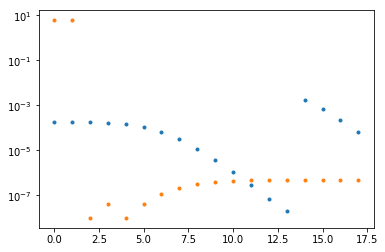

In [208]:
#plt.semilogy(wymL_0,'.')
#plt.semilogy(wymM_0,'.')
plt.semilogy(wymMM_0,'.') #this one
#plt.semilogy(wymML_0,'.')
#plt.semilogy(wymMML_0,'.')
plt.semilogy(wymMMLL_0,'.') #this one

In [29]:
lig_concs - (wymL_0 + wymML_0 + wymMML_0 + 2*wymMMLL_0)

array([ -1.20745106e+01,  -1.20765777e+01,  -2.00000000e-08,
        -7.00000000e-08,   1.00000000e-08,   9.99999999e-09,
         1.38777878e-17,   2.77555756e-17,  -9.99999994e-09,
        -9.99999994e-09,   9.99999994e-09,   4.44089210e-16,
         9.99999905e-09,   0.00000000e+00,  -1.00000008e-08,
        -9.99999372e-09,  -9.99999372e-09,  -9.99997951e-09])

In [30]:
sp.stats.mode(wymar[1][:,0,2])

ModeResult(mode=array([ 0.00018724]), count=array([50]))

In [154]:
def find_best_root2(data,max_lig_index,target_index,lig_max):
    """Returns "most reasonable" root solution from array of solutions
    based on known variables
    
    data -- the array of root solutions for a given binding equation
    max_lig_index -- length of starting ligand concentrations array
    target_index -- index of target solution in root solution tuple
    lig_max -- total receptor concentration used for solution
    """
    holder = []
    for i in range(max_lig_index):
        temp = data[:,i,target_index]
        try:
            sp.stats.mode(temp)[0][0] > 0
            holder.append(sp.stats.mode(temp)[0][0])
        except: print('negative root encountered')
        
        
    return np.array(holder)

In [155]:
wymL_0_br2 = find_best_root2(wymar[1],18,0,150)

In [217]:
br2_wymL_0 = find_best_root2(wymar[0],18,0,150)
br2_wymM_0 = find_best_root2(wymar[0],18,1,150)
br2_wymMM_0 = find_best_root2(wymar[0],18,2,150)
br2_wymML_0 = find_best_root2(wymar[0],18,3,150)
br2_wymMML_0 = find_best_root2(wymar[0],18,4,150)
br2_wymMMLL_0 = find_best_root2(wymar[0],18,5,150)

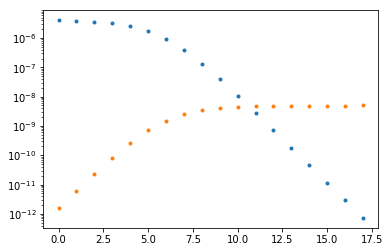

In [218]:
#plt.semilogy(br2_wymL_0,'.')
#plt.semilogy(br2_wymM_0,'.')
plt.semilogy(br2_wymMM_0,'.') #this one
#plt.semilogy(br2_wymML_0,'.')
#plt.semilogy(br2_wymMML_0,'.')
plt.semilogy(br2_wymMMLL_0,'.') #this one

In [233]:
def smdev(ys,win=5,poly=3):
    smoothed = signal.savgol_filter(ys,window_length=win,polyorder=poly)
    rmse = np.sqrt(np.mean((((ys-smoothed)/ys)**2)))
    return rmse

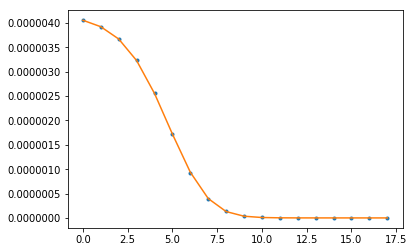

In [226]:
plt.plot(br2_wymMM_0,'.')
plt.plot(signal.savgol_filter(br2_wymMM_0,window_length=5,polyorder=3))

In [234]:
for i in [wymL_0, wymM_0, wymMM_0, wymML_0, wymMML_0, wymMMLL_0]:
    print(smdev(i))

0.0205231217485
0.0119658193605
6506.99020819
0.00470482860718
0.011878520007
36726493.3428


In [215]:
for i in [br2_wymL_0, br2_wymM_0, br2_wymMM_0, br2_wymML_0, br2_wymMML_0, br2_wymMMLL_0]:
    print(smdev(i))

0.0204291867372
0.0124073856445
0.433475616276
0.00297725194427
0.0138310077127
0.153006241592


In [83]:
wymar[0].shape

(100, 18, 6)

In [105]:
roots = wymar[0][:,6,4]
unes = np.unique(roots,return_counts=True,return_index=True)

In [106]:
linked = np.stack((unes[2],unes[0]),axis=1)

In [107]:
linked

array([[  1.00000000e+00,  -1.25753070e+01],
       [  2.00000000e+00,  -8.10671239e+00],
       [  3.00000000e+00,  -8.10671239e+00],
       [  1.00000000e+00,   2.35007131e-07],
       [  3.00000000e+00,   2.35007131e-07],
       [  1.30000000e+01,   2.35007131e-07],
       [  2.60000000e+01,   2.35007131e-07],
       [  2.30000000e+01,   2.35007131e-07],
       [  1.50000000e+01,   2.35007131e-07],
       [  1.00000000e+00,   1.54907827e-05],
       [  1.00000000e+00,   7.30380442e-05],
       [  1.00000000e+00,   7.63112948e-05],
       [  2.00000000e+00,   4.64147292e-04],
       [  4.00000000e+00,   4.64147292e-04],
       [  2.00000000e+00,   4.64147292e-04],
       [  2.00000000e+00,   4.64147292e-04]])

In [108]:
unes

(array([ -1.25753070e+01,  -8.10671239e+00,  -8.10671239e+00,
          2.35007131e-07,   2.35007131e-07,   2.35007131e-07,
          2.35007131e-07,   2.35007131e-07,   2.35007131e-07,
          1.54907827e-05,   7.30380442e-05,   7.63112948e-05,
          4.64147292e-04,   4.64147292e-04,   4.64147292e-04,
          4.64147292e-04]),
 array([38, 64, 27, 17, 44,  2,  4,  0,  1,  7, 74, 22, 72,  9, 45, 11]),
 array([ 1,  2,  3,  1,  3, 13, 26, 23, 15,  1,  1,  1,  2,  4,  2,  2]))

In [164]:
import numpy as np

def outliers_modified_z_score(ys):
    threshold = 5

    median_y = np.median(ys)
    median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in ys])
    modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y
                         for y in ys]
    return np.where(np.abs(modified_z_scores) > threshold)

In [148]:
outliers_modified_z_score(br2_wymMML_0)

(array([], dtype=int64),)

In [149]:
outliers_modified_z_score(wymMMLL_0)

(array([0, 1]),)

In [119]:
br2_wymMML_0[6]

2.3500713053199924e-07

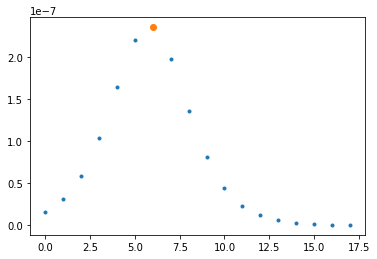

In [113]:
plt.plot(br2_wymMML_0,'.')
plt.plot(6,br2_wymMML_0[6],'o')

In [114]:
from scipy import signal

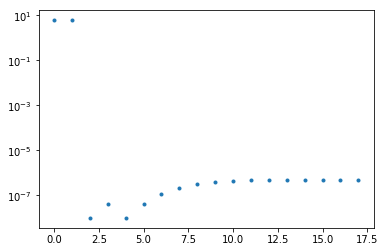

In [153]:
plt.semilogy(wymMMLL_0,'.')
#plt.plot(signal.medfilt(wymMMLL_0,kern),'x')

In [116]:
signal.medfilt(br2_wymMML_0)[6]

2.19792841320861e-07

In [117]:
br2_wymMML_0[6]

2.3500713053199924e-07